In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import zipfile
import gdown
import matplotlib.image as mpimg

In [2]:
image_extensions = {'.jpg', '.jpeg', '.png'}

In [3]:
working_dir = os.getcwd()
base_dir = os.path.join(working_dir, "All_Data")
classes = os.listdir(base_dir)
classes

['With_Peter_All', '.DS_Store', 'Without_Peter_All']

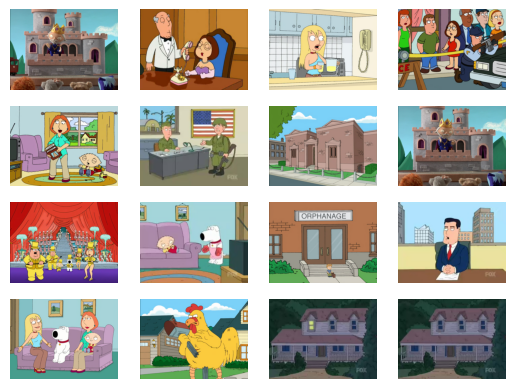

In [4]:
fig = plt.gcf()

with_dir = os.path.join('All_Data/With_Peter_All')
without_dir = os.path.join('All_Data/Without_Peter_All')
with_names = os.listdir(with_dir)
without_names = os.listdir(without_dir)

pic_index = 100

with_images = [os.path.join(with_dir, fname)
              for fname in with_dir[pic_index-16:pic_index]]
without_images = [os.path.join(without_dir, fname)
              for fname in without_names[pic_index-16:pic_index]]

for i, img_path in enumerate(with_images + without_images):
    sp = plt.subplot(4, 4, i+1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [5]:
# Create datasets
train_datagen = image_dataset_from_directory(base_dir,
                                                  image_size=(320,240),
                                                  subset='training',
                                                  seed = 1,
                                                  validation_split=0.2,
                                                  batch_size= 32)
test_datagen = image_dataset_from_directory(base_dir,
                                                  image_size=(320,240),
                                                  subset='validation',
                                                  seed = 1,
                                                  validation_split=0.2,
                                                  batch_size= 32)

Found 12768 files belonging to 2 classes.
Using 10215 files for training.
Found 12768 files belonging to 2 classes.
Using 2553 files for validation.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_dataset(image, label):
    # Apply ResNet50 preprocessing
    image = preprocess_input(image)
    return image, label

# Preprocess datasets using the custom function
train_datagen = train_datagen.map(preprocess_dataset)
test_datagen = test_datagen.map(preprocess_dataset)

In [7]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(320, 240, 3))
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 10, 8, 2048)    │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    20,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,091,713 (172.01 MB)

 Trainable params: 21,500,929 (82.02 MB)

 Non-trainable params: 23,590,784 (89.99 MB)

In [9]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
history = model.fit(train_datagen,
          epochs=10,
          validation_data=test_datagen)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.8827 - loss: 0.2865 - val_accuracy: 0.9675 - val_loss: 0.0998
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.9804 - loss: 0.0573 - val_accuracy: 0.9675 - val_loss: 0.1156
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9903 - loss: 0.0330 - val_accuracy: 0.9597 - val_loss: 0.1273
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.9868 - loss: 0.0355 - val_accuracy: 0.9734 - val_loss: 0.0974
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.9903 - loss: 0.0274 - val_accuracy: 0.9557 - val_loss: 0.1566
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.9901 - loss: 0.0368 - val_accuracy: 0.9773 - val_loss: 0.0937
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.9928 - loss: 0.0218 - val_accuracy: 0.9761 - val_loss: 0.0774
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.9945 - loss: 0.0185 - val_accu

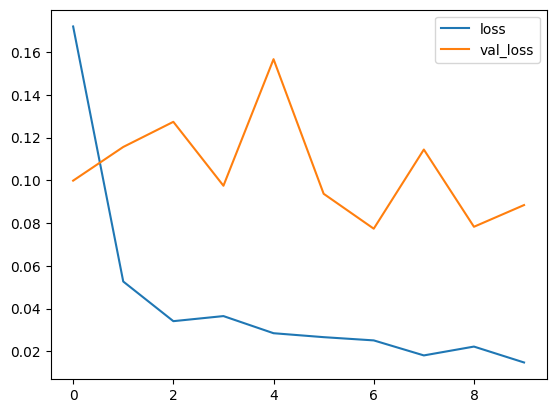

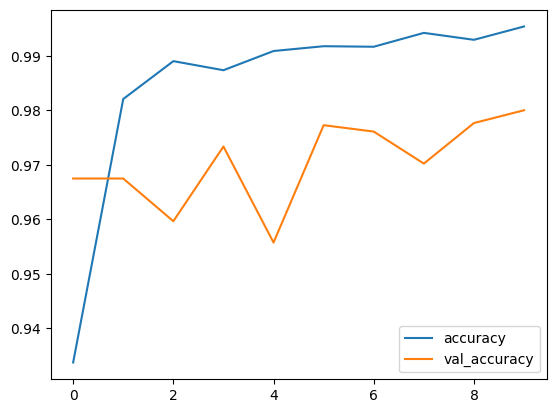

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_dir = 'Unseen_Test'

test_image1_path = os.path.join(test_dir, "out-10000.jpg")
test_image2_path = os.path.join(test_dir, "out-20000.jpg")
test_image3_path = os.path.join(test_dir, "out-30000.jpg")
test_image4_path = os.path.join(test_dir, "out-40000.jpg")
test_image5_path = os.path.join(test_dir, "out-50000.jpg")
test_image6_path = os.path.join(test_dir, "out-60000.jpg")

image_paths = [test_image1_path, 
               test_image2_path, 
               test_image3_path, 
               test_image4_path, 
               test_image5_path, 
               test_image6_path]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
With Peter


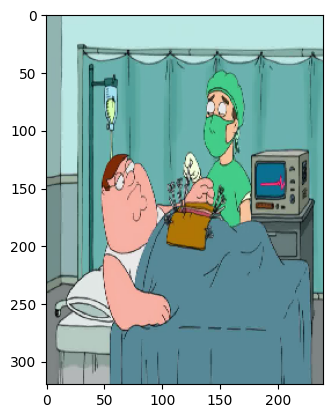

In [13]:

test_image = load_img(test_image1_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Without Peter


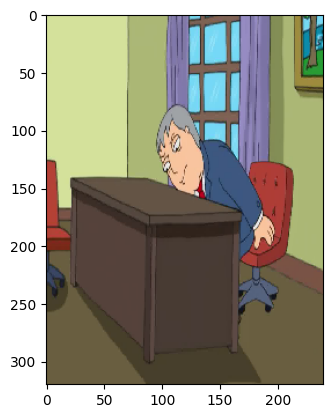

In [14]:

test_image = load_img(test_image2_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Without Peter


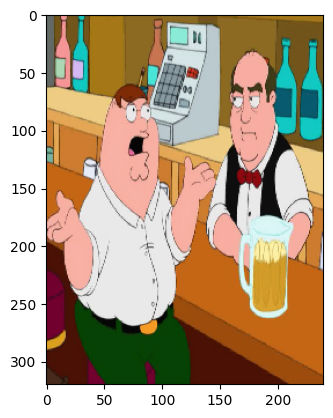

In [15]:

test_image = load_img(test_image3_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Without Peter


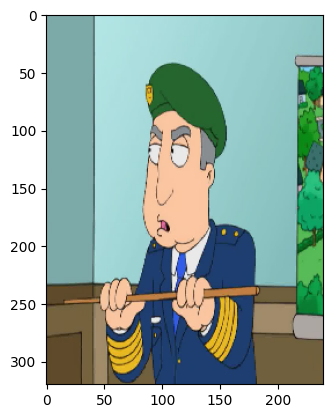

In [16]:

test_image = load_img(test_image4_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
With Peter


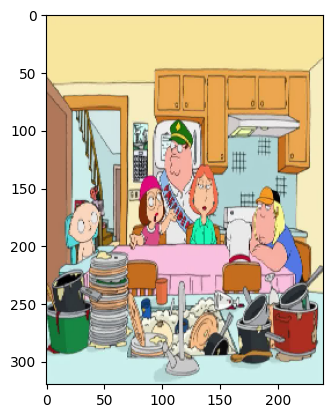

In [17]:

test_image = load_img(test_image5_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Without Peter


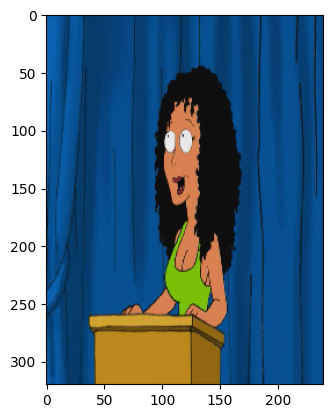

In [18]:

test_image = load_img(test_image6_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")


In [19]:
#model.save('resnet50_80_20.keras')

In [20]:
tp = 0 
fp = 0 
tn = 0 
fn = 0  

for images, labels in test_datagen:
    preds = model.predict(images, verbose=0)
    # threshold=0.5
    binary_preds = (preds > 0.5).astype(int).flatten()
    labels = labels.numpy().flatten()
    
    for pred, true_label in zip(binary_preds, labels):
        if pred == 1 and true_label == 1:
            tp += 1  # Correctly predicted 'With Peter'
        elif pred == 1 and true_label == 0:
            fp += 1  # Incorrectly predicted 'With Peter'
        elif pred == 0 and true_label == 0:
            tn += 1  # Correctly predicted 'Without Peter'
        elif pred == 0 and true_label == 1:
            fn += 1  # Incorrectly predicted 'Without Peter'

# Print results
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


True Positives (TP): 1331
False Positives (FP): 30
True Negatives (TN): 1171
False Negatives (FN): 21


2024-12-06 05:37:23.928952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
directory = "frames_resized"

files = [f for f in os.listdir(directory) if f.startswith("out-") and f.endswith(".jpg")]

sorted_files = sorted(files, key=lambda x: int(x.split('-')[1].split('.')[0]))

In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

classified = []

index = 0
for file in sorted_files:
    file_path = os.path.join(directory, file)
    test_image = load_img(file_path,target_size=(320,240))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis=0)
    result = model.predict(test_image,verbose=0)
    if(result<0.5):
        peter = 1
    else:
        peter = 0
    classified.append(peter)
    #if(index<100):
        #print(file,peter)
    index += 1


In [23]:
print(classified)


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [36]:
directory = "frames_classified/With_Peter"

files = [f for f in os.listdir(directory) if f.startswith("out-") and f.endswith(".jpg")]

my_list = [0 for _ in range(len(classified))] 

for file in files:
    integer_part = int(file.split('-')[1].split('.')[0])
    integer_part = int(integer_part/10 -1)
    my_list[integer_part] = 1

print(my_list)
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 